#ctb 0.62

## ctb调参

# 0.50151896000 lgb

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate


KeyboardInterrupt: ignored

In [1]:
!mkdir -p GuodongDrive
!google-drive-ocamlfuse GuodongDrive
import os
os.chdir("GuodongDrive")
os.chdir("ccf/carsale")
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
0825ccf_carsale.csv	   baseline2.ipynb
0825ccf_car_sales_lgb.csv  catboost_info
083101_car_sale.csv	   ccf_car_sales082601.csv
083101sub.csv		   ccf_car_sales082602.csv
083103_car_sale.csv	   ccf_car_sales.csv
083103sub.csv		   ccf_car_sales_lgb.csv
090101car_sales.csv	   evaluation_public.csv
090102car_sales.csv	   evaluation_public_new.csv
090103car_sales.csv	   evaluation_public_xishao.csv
090201car_sales.csv	   guize1-new.ipynb
baseline082601.ipynb	   GuodongDrive
baseline082701.ipynb	   ronghe_car_sales.csv
baseline082702.ipynb	   submit_example.csv
baseline082703.ipynb	   train_sales_data.csv
baseline082704.ipynb	   train_sales_new.csv
baseline083101.ipynb	   train_search_data.csv
baseline083102.ipynb	   train_user_reply_data.csv
baseline090101.ipynb	   Untitled0.ipynb
baseline1_copy.ipynb	   xishao_car_sale.csv
baseline1.ipynb		   统计_car_sales.csv


In [2]:
!pip install --upgrade catboost

     |████████████████████████████████| 61.9MB 1.2MB/s 


In [0]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [0]:
from sklearn import linear_model, svm, gaussian_process
from sklearn.ensemble import RandomForestRegressor


思路：  
- 这种popularity	carCommentVolum	newsReplyVolum我感觉都是增长的，可以预测出来,我们可以单独用模型将接下来四个月份的这三个指标预测出来

- 在统计分数的时候所用的验证集，已经作为模型的验证集训练过，所以得到的分数会偏高
应该用split先将train_set分为train和valid，再去用17年最后的四个月作为统计分数的指标

- 可以用KFold进行train_set和valid_set的训练

- 他在训练时将特征model和type换成另一种表现方式，不妨把这种表现方式设为新的特征，model和type依然保留作为特征

-预测流量指数考虑clfs = {
        'svm':svm.SVR(), 
        'RandomForestRegressor':RandomForestRegressor(n_estimators=400),
        'BayesianRidge':linear_model.BayesianRidge()
       }
for clf in clfs:
    try:
        clfs[clf].fit(X_train, y_train)
        y_pred = clfs[clf].predict(X_test)
        print(clf + " cost:" + str(np.sum(y_pred-y_test)/len(y_pred)) )

In [0]:
train_sales_data = pd.read_csv('train_sales_data.csv')
train_search_data = pd.read_csv('train_search_data.csv')
train_user_reply_data = pd.read_csv('train_user_reply_data.csv')
test = pd.read_csv('evaluation_public.csv')

In [6]:
data = pd.concat([train_sales_data, test], ignore_index=True)
data = data.merge(train_search_data, 'left', on=['province', 'adcode', 'model', 'regYear', 'regMonth'])
data = data.merge(train_user_reply_data, 'left', on=['model', 'regYear', 'regMonth'])
data.head(10)

,adcode,bodyType,forecastVolum,id,model,province,regMonth,regYear,salesVolume,popularity,carCommentVolum,newsReplyVolum
0,310000,SUV,NaN,NaN,3c974920a76ac9c1,上海,1,2016,292.0,1479.0,11.0,106.0
1,530000,SUV,NaN,NaN,3c974920a76ac9c1,云南,1,2016,466.0,1594.0,11.0,106.0
2,150000,SUV,NaN,NaN,3c974920a76ac9c1,内蒙古,1,2016,257.0,1479.0,11.0,106.0
3,110000,SUV,NaN,NaN,3c974920a76ac9c1,北京,1,2016,408.0,2370.0,11.0,106.0
4,510000,SUV,NaN,NaN,3c974920a76ac9c1,四川,1,2016,610.0,3562.0,11.0,106.0
5,340000,SUV,NaN,NaN,3c974920a76ac9c1,安徽,1,2016,206.0,1314.0,11.0,106.0
6,370000,SUV,NaN,NaN,3c974920a76ac9c1,山东,1,2016,503.0,3476.0,11.0,106.0
7,140000,SUV,NaN,NaN,3c974920a76ac9c1,山西,1,2016,236.0,1422.0,11.0,106.0
8,440000,SUV,NaN,NaN,3c974920a76ac9c1,广东,1,2016,3635.0,7182.0,11.0,106.0
9,450000,SUV,NaN,NaN,3c974920a76ac9c1,广西,1,2016,450.0,1163.0,11.0,106.0


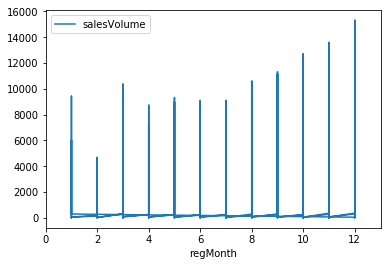

In [0]:
data.plot(x= 'regMonth',y = 'salesVolume',xlim=(0, 13))

 **每年二月份买车都比较少，感觉应该单独预测**

**每年十二月份比较多，感觉可以去掉**

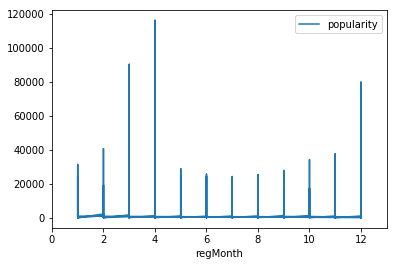

In [0]:
data.plot(x= 'regMonth',y = 'popularity',xlim=(0, 13))

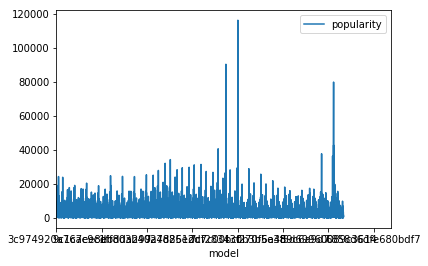

In [0]:
data.plot(x= 'model',y = 'popularity')

In [0]:
data.tail(5)

,adcode,bodyType,forecastVolum,id,model,province,regMonth,regYear,salesVolume,popularity,carCommentVolum,newsReplyVolum
36955,350000,NaN,NaN,5364.0,a9a43d1a7ecbe75d,福建,4,2018,NaN,NaN,NaN,NaN
36956,210000,NaN,NaN,5365.0,a9a43d1a7ecbe75d,辽宁,4,2018,NaN,NaN,NaN,NaN
36957,500000,NaN,NaN,5366.0,a9a43d1a7ecbe75d,重庆,4,2018,NaN,NaN,NaN,NaN
36958,610000,NaN,NaN,5367.0,a9a43d1a7ecbe75d,陕西,4,2018,NaN,NaN,NaN,NaN
36959,230000,NaN,NaN,5368.0,a9a43d1a7ecbe75d,黑龙江,4,2018,NaN,NaN,NaN,NaN


In [0]:
data['label'] = data['salesVolume']
data['id'] = data['id'].fillna(0).astype(int)
del data['salesVolume'], data['forecastVolum']
data['bodyType_2'] = data['model'].map(train_sales_data.drop_duplicates('model').set_index('model')['bodyType'])
data['model'].head()
#一种model可能对应多种type
data['model_2'] = data['model']

In [0]:
data.head(10)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,bodyType_2,model_2
0,310000,SUV,0,3c974920a76ac9c1,上海,1,2016,1479.0,11.0,106.0,292.0,SUV,3c974920a76ac9c1
1,530000,SUV,0,3c974920a76ac9c1,云南,1,2016,1594.0,11.0,106.0,466.0,SUV,3c974920a76ac9c1
2,150000,SUV,0,3c974920a76ac9c1,内蒙古,1,2016,1479.0,11.0,106.0,257.0,SUV,3c974920a76ac9c1
3,110000,SUV,0,3c974920a76ac9c1,北京,1,2016,2370.0,11.0,106.0,408.0,SUV,3c974920a76ac9c1
4,510000,SUV,0,3c974920a76ac9c1,四川,1,2016,3562.0,11.0,106.0,610.0,SUV,3c974920a76ac9c1
5,340000,SUV,0,3c974920a76ac9c1,安徽,1,2016,1314.0,11.0,106.0,206.0,SUV,3c974920a76ac9c1
6,370000,SUV,0,3c974920a76ac9c1,山东,1,2016,3476.0,11.0,106.0,503.0,SUV,3c974920a76ac9c1
7,140000,SUV,0,3c974920a76ac9c1,山西,1,2016,1422.0,11.0,106.0,236.0,SUV,3c974920a76ac9c1
8,440000,SUV,0,3c974920a76ac9c1,广东,1,2016,7182.0,11.0,106.0,3635.0,SUV,3c974920a76ac9c1
9,450000,SUV,0,3c974920a76ac9c1,广西,1,2016,1163.0,11.0,106.0,450.0,SUV,3c974920a76ac9c1


In [0]:
data.tail(10)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label
36950,130000,SUV,5359,a9a43d1a7ecbe75d,河北,4,2018,NaN,NaN,NaN,NaN
36951,410000,SUV,5360,a9a43d1a7ecbe75d,河南,4,2018,NaN,NaN,NaN,NaN
36952,330000,SUV,5361,a9a43d1a7ecbe75d,浙江,4,2018,NaN,NaN,NaN,NaN
36953,420000,SUV,5362,a9a43d1a7ecbe75d,湖北,4,2018,NaN,NaN,NaN,NaN
36954,430000,SUV,5363,a9a43d1a7ecbe75d,湖南,4,2018,NaN,NaN,NaN,NaN
36955,350000,SUV,5364,a9a43d1a7ecbe75d,福建,4,2018,NaN,NaN,NaN,NaN
36956,210000,SUV,5365,a9a43d1a7ecbe75d,辽宁,4,2018,NaN,NaN,NaN,NaN
36957,500000,SUV,5366,a9a43d1a7ecbe75d,重庆,4,2018,NaN,NaN,NaN,NaN
36958,610000,SUV,5367,a9a43d1a7ecbe75d,陕西,4,2018,NaN,NaN,NaN,NaN
36959,230000,SUV,5368,a9a43d1a7ecbe75d,黑龙江,4,2018,NaN,NaN,NaN,NaN


In [8]:
for i in ['bodyType_2', 'model_2']:
    data[i] = data[i].map(dict(zip(data[i].unique(), range(data[i].nunique()))))#用这个函数可以查看数据有多少个不同值。

data.head(10)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,bodyType_2,model_2
0,310000,SUV,0,3c974920a76ac9c1,上海,1,2016,1479.0,11.0,106.0,292.0,0,0
1,530000,SUV,0,3c974920a76ac9c1,云南,1,2016,1594.0,11.0,106.0,466.0,0,0
2,150000,SUV,0,3c974920a76ac9c1,内蒙古,1,2016,1479.0,11.0,106.0,257.0,0,0
3,110000,SUV,0,3c974920a76ac9c1,北京,1,2016,2370.0,11.0,106.0,408.0,0,0
4,510000,SUV,0,3c974920a76ac9c1,四川,1,2016,3562.0,11.0,106.0,610.0,0,0
5,340000,SUV,0,3c974920a76ac9c1,安徽,1,2016,1314.0,11.0,106.0,206.0,0,0
6,370000,SUV,0,3c974920a76ac9c1,山东,1,2016,3476.0,11.0,106.0,503.0,0,0
7,140000,SUV,0,3c974920a76ac9c1,山西,1,2016,1422.0,11.0,106.0,236.0,0,0
8,440000,SUV,0,3c974920a76ac9c1,广东,1,2016,7182.0,11.0,106.0,3635.0,0,0
9,450000,SUV,0,3c974920a76ac9c1,广西,1,2016,1163.0,11.0,106.0,450.0,0,0


zip() 函数用于将可迭代的对象作为参数，

将对象中对应的元素打包成一个个元组，

然后返回由这些元组组成的列表。

如果各个迭代器的元素个数不一致，则返回列表长度与最短的对象相同，

a = [1,2,3]

 b = [4,5,6]

 c = [4,5,6,7,8]

 zipped = zip(a,b)  # 打包为元组的列表

[(1, 4), (2, 5), (3, 6)]

zip(a,c)              # 元素个数与最短的列表一致

[(1, 4), (2, 5), (3, 6)]

In [9]:
data['mt'] = (data['regYear'] - 2016) * 12 + data['regMonth']

# 'popularity', 'carCommentVolum', 'newsReplyVolum','label'/

shift_feat = []

data['model_adcode'] = data['adcode'] + data['model_2']
data['model_adcode_mt'] = data['model_adcode'] * 100 + data['mt']
for i in [11]:
    i = i + 1
    shift_feat.append('shift_model_adcode_mt_label_{0}'.format(i))
    data['model_adcode_mt_{0}'.format(i)] = data['model_adcode_mt'] + i
    data_last = data[~data.label.isnull()].set_index('model_adcode_mt_{0}'.format(i))
    data['shift_model_adcode_mt_label_{0}'.format(i)] = data['model_adcode_mt'].map(data_last['label'])

shift_feat

['shift_model_adcode_mt_label_12']

In [0]:
data.head(10)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,bodyType_2,model_2,mt,model_adcode,model_adcode_mt,model_adcode_mt_12,shift_model_adcode_mt_label_12
0,310000,SUV,0,3c974920a76ac9c1,上海,1,2016,1479.0,11.0,106.0,292.0,0,0,1,310000,31000001,31000013,NaN
1,530000,SUV,0,3c974920a76ac9c1,云南,1,2016,1594.0,11.0,106.0,466.0,0,0,1,530000,53000001,53000013,NaN
2,150000,SUV,0,3c974920a76ac9c1,内蒙古,1,2016,1479.0,11.0,106.0,257.0,0,0,1,150000,15000001,15000013,NaN
3,110000,SUV,0,3c974920a76ac9c1,北京,1,2016,2370.0,11.0,106.0,408.0,0,0,1,110000,11000001,11000013,NaN
4,510000,SUV,0,3c974920a76ac9c1,四川,1,2016,3562.0,11.0,106.0,610.0,0,0,1,510000,51000001,51000013,NaN
5,340000,SUV,0,3c974920a76ac9c1,安徽,1,2016,1314.0,11.0,106.0,206.0,0,0,1,340000,34000001,34000013,NaN
6,370000,SUV,0,3c974920a76ac9c1,山东,1,2016,3476.0,11.0,106.0,503.0,0,0,1,370000,37000001,37000013,NaN
7,140000,SUV,0,3c974920a76ac9c1,山西,1,2016,1422.0,11.0,106.0,236.0,0,0,1,140000,14000001,14000013,NaN
8,440000,SUV,0,3c974920a76ac9c1,广东,1,2016,7182.0,11.0,106.0,3635.0,0,0,1,440000,44000001,44000013,NaN
9,450000,SUV,0,3c974920a76ac9c1,广西,1,2016,1163.0,11.0,106.0,450.0,0,0,1,450000,45000001,45000013,NaN


In [0]:
data.tail(10)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,mt,model_adcode,model_adcode_mt,model_adcode_mt_12,shift_model_adcode_mt_label_12
36950,130000,0,5359,59,河北,4,2018,NaN,NaN,NaN,NaN,28,130059,13005928,13005940,95.0
36951,410000,0,5360,59,河南,4,2018,NaN,NaN,NaN,NaN,28,410059,41005928,41005940,114.0
36952,330000,0,5361,59,浙江,4,2018,NaN,NaN,NaN,NaN,28,330059,33005928,33005940,317.0
36953,420000,0,5362,59,湖北,4,2018,NaN,NaN,NaN,NaN,28,420059,42005928,42005940,183.0
36954,430000,0,5363,59,湖南,4,2018,NaN,NaN,NaN,NaN,28,430059,43005928,43005940,301.0
36955,350000,0,5364,59,福建,4,2018,NaN,NaN,NaN,NaN,28,350059,35005928,35005940,88.0
36956,210000,0,5365,59,辽宁,4,2018,NaN,NaN,NaN,NaN,28,210059,21005928,21005940,102.0
36957,500000,0,5366,59,重庆,4,2018,NaN,NaN,NaN,NaN,28,500059,50005928,50005940,134.0
36958,610000,0,5367,59,陕西,4,2018,NaN,NaN,NaN,NaN,28,610059,61005928,61005940,212.0
36959,230000,0,5368,59,黑龙江,4,2018,NaN,NaN,NaN,NaN,28,230059,23005928,23005940,67.0


In [0]:
num_feat = ['adcode', 'regMonth', 'regYear', 'popularity', 'carCommentVolum', 'newsReplyVolum', 'bodyType_2', 'model_2']+ shift_feat
cate_feat = ['bodyType', 'model', 'province']

# lbl = LabelEncoder()
# for i in cate_feat:
#   data[i] = lbl.fit_transform(data[i].astype(str))
# for i in cate_feat:
#     data[i] = data[i].astype('category')
features = num_feat + cate_feat

In [0]:
data.head(10)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,bodyType_2,model_2,mt,model_adcode,model_adcode_mt,model_adcode_mt_12,shift_model_adcode_mt_label_12
0,310000,2,0,13,0,1,2016,1479.0,11.0,106.0,292.0,0,0,1,310000,31000001,31000013,NaN
1,530000,2,0,13,1,1,2016,1594.0,11.0,106.0,466.0,0,0,1,530000,53000001,53000013,NaN
2,150000,2,0,13,2,1,2016,1479.0,11.0,106.0,257.0,0,0,1,150000,15000001,15000013,NaN
3,110000,2,0,13,3,1,2016,2370.0,11.0,106.0,408.0,0,0,1,110000,11000001,11000013,NaN
4,510000,2,0,13,4,1,2016,3562.0,11.0,106.0,610.0,0,0,1,510000,51000001,51000013,NaN
5,340000,2,0,13,5,1,2016,1314.0,11.0,106.0,206.0,0,0,1,340000,34000001,34000013,NaN
6,370000,2,0,13,6,1,2016,3476.0,11.0,106.0,503.0,0,0,1,370000,37000001,37000013,NaN
7,140000,2,0,13,7,1,2016,1422.0,11.0,106.0,236.0,0,0,1,140000,14000001,14000013,NaN
8,440000,2,0,13,8,1,2016,7182.0,11.0,106.0,3635.0,0,0,1,440000,44000001,44000013,NaN
9,450000,2,0,13,9,1,2016,1163.0,11.0,106.0,450.0,0,0,1,450000,45000001,45000013,NaN


**划分训练集，线下验证集，测试集index**

In [0]:
# data['n_label'] = data['label'] / data.groupby('model')['label'].transform('mean')
train_idx = (data['mt'] <= 20)

valid_idx = (data['mt'].between(21, 24))

test_idx = (data['mt'] > 24)

In [0]:
data['model_weight'] = data.groupby('model_2')['label'].transform('mean')
data['n_label'] = data['label'] / data['model_weight']

In [0]:
data.head(10)

,adcode,bodyType,id,model,province,regMonth,regYear,popularity,carCommentVolum,newsReplyVolum,label,bodyType_2,model_2,mt,model_adcode,model_adcode_mt,model_adcode_mt_12,shift_model_adcode_mt_label_12,model_weight,n_label
0,310000,SUV,0,3c974920a76ac9c1,上海,1,2016,1479.0,11.0,106.0,292.0,0,0,1,310000,31000001,31000013,NaN,444.518939,0.656890
1,530000,SUV,0,3c974920a76ac9c1,云南,1,2016,1594.0,11.0,106.0,466.0,0,0,1,530000,53000001,53000013,NaN,444.518939,1.048324
2,150000,SUV,0,3c974920a76ac9c1,内蒙古,1,2016,1479.0,11.0,106.0,257.0,0,0,1,150000,15000001,15000013,NaN,444.518939,0.578153
3,110000,SUV,0,3c974920a76ac9c1,北京,1,2016,2370.0,11.0,106.0,408.0,0,0,1,110000,11000001,11000013,NaN,444.518939,0.917846
4,510000,SUV,0,3c974920a76ac9c1,四川,1,2016,3562.0,11.0,106.0,610.0,0,0,1,510000,51000001,51000013,NaN,444.518939,1.372270
5,340000,SUV,0,3c974920a76ac9c1,安徽,1,2016,1314.0,11.0,106.0,206.0,0,0,1,340000,34000001,34000013,NaN,444.518939,0.463422
6,370000,SUV,0,3c974920a76ac9c1,山东,1,2016,3476.0,11.0,106.0,503.0,0,0,1,370000,37000001,37000013,NaN,444.518939,1.131560
7,140000,SUV,0,3c974920a76ac9c1,山西,1,2016,1422.0,11.0,106.0,236.0,0,0,1,140000,14000001,14000013,NaN,444.518939,0.530911
8,440000,SUV,0,3c974920a76ac9c1,广东,1,2016,7182.0,11.0,106.0,3635.0,0,0,1,440000,44000001,44000013,NaN,444.518939,8.177379
9,450000,SUV,0,3c974920a76ac9c1,广西,1,2016,1163.0,11.0,106.0,450.0,0,0,1,450000,45000001,45000013,NaN,444.518939,1.012330


In [13]:
train_x = data[train_idx][features]
train_y = data[train_idx]['n_label']
print("train_x is\n")
#print(train_x)
print("-----------------------------------")
valid_x = data[valid_idx][features]
valid_y = data[valid_idx]['n_label']
print("valid_x is\n")
#print(valid_x)
print("-----------------------------------")

train_x is

-----------------------------------
valid_x is

-----------------------------------


In [0]:
parameters = {
     'n_estimators': [2000,5000,6000],
   # 'learning_rate':[0.02,0.05,0.1],
# 	'num_leaves':[32,64], 
# 	'reg_alpha':[0.,1], 
#  	'reg_lambda':[0.01,0.1],
#    'max_depth':[-1],
#    'min_child_samples':[5,20],
    'subsample':[0.7,0.8],
     'max_depth': [5,6,7],
#      'n_estimators' : [1000,5000],
      'thread_count': [3,4,5]
    # 'learning_rate': [0.01,0.05,0.1],
 
}

ctb_params = {
    'n_estimators': 5000,
    'learning_rate': 0.02,
    'random_seed': 2019,
    'reg_lambda': 0.1,
    'subsample': 0.7,
    'bootstrap_type': 'Bernoulli',
    'boosting_type': 'Plain',
    'one_hot_max_size': 10,
    'rsm': 0.5,
    'leaf_estimation_iterations': 5,
    'use_best_model': True,
    'max_depth': 6,
    'verbose': -1,
    'thread_count': 4
}

ctb_model = cat.CatBoostRegressor(**ctb_params, cat_features=cate_feat, early_stopping_rounds=100)

# ctb_model.fit(train_x, train_y,
#            eval_set=[(valid_x, valid_y)],
                     
                     
#                       #sample_weight=train_data.loc[train_idx]['sample_weight'],
#                       verbose=100)

# lgb_model = lgb.LGBMRegressor(
#     num_leaves=32, reg_alpha=1, reg_lambda=0.1, objective='mse',
#     max_depth=-1, learning_rate=0.05, min_child_samples=5, random_state=np.random.randint(1000),
#     n_estimators=5000, subsample=0.8, colsample_bytree=0.8,n_jobs=-1
# )

clf = GridSearchCV( ctb_model, param_grid= parameters, scoring='neg_mean_squared_error',cv=5, verbose=10 )
clf.fit(train_x, train_y, eval_set=[
    (valid_x, valid_y),
],  verbose=100)
#clf.fit(train_x, train_y) #你和模型
clf.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] max_depth=5, n_estimators=2000, subsample=0.7, thread_count=3 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 1.2970128	test: 1.5204570	best: 1.5204570 (0)	total: 63.3ms	remaining: 2m 6s
100:	learn: 0.6218996	test: 0.7867989	best: 0.7867989 (100)	total: 1.59s	remaining: 30s
200:	learn: 0.5314127	test: 0.6434878	best: 0.6434878 (200)	total: 3.13s	remaining: 28s
300:	learn: 0.4892812	test: 0.5850512	best: 0.5850512 (300)	total: 4.74s	remaining: 26.8s
400:	learn: 0.4634702	test: 0.5589942	best: 0.5589448 (399)	total: 6.32s	remaining: 25.2s
500:	learn: 0.4425921	test: 0.5388002	best: 0.5388002 (500)	total: 7.92s	remaining: 23.7s
600:	learn: 0.4238608	test: 0.5229966	best: 0.5229966 (600)	total: 9.61s	remaining: 22.4s
700:	learn: 0.4087946	test: 0.5139274	best: 0.5139242 (699)	total: 11.2s	remaining: 20.8s
800:	learn: 0.3941842	test: 0.5047828	best: 0.5047828 (800)	total: 12.8s	remaining: 19.2s
900:	learn: 0.3812472	test: 0.4983474	best: 0.4982763 (899)	total: 14.4s	remaining: 17.6s
1000:	learn: 0.3706531	test: 0.4930851	best: 0.4930851 (1000)	total: 16.1s	remaining: 16s
1100:	learn: 0.36

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.7s remaining:    0.0s


0:	learn: 1.3178396	test: 1.5204228	best: 1.5204228 (0)	total: 15.1ms	remaining: 30.2s
100:	learn: 0.6590431	test: 0.7928855	best: 0.7928855 (100)	total: 1.57s	remaining: 29.5s
200:	learn: 0.5666161	test: 0.6380457	best: 0.6380457 (200)	total: 3.1s	remaining: 27.8s
300:	learn: 0.5274899	test: 0.5845431	best: 0.5845431 (300)	total: 4.68s	remaining: 26.4s
400:	learn: 0.4984900	test: 0.5562177	best: 0.5562177 (400)	total: 6.36s	remaining: 25.4s
500:	learn: 0.4763047	test: 0.5371557	best: 0.5371557 (500)	total: 7.92s	remaining: 23.7s
600:	learn: 0.4593527	test: 0.5227137	best: 0.5227137 (600)	total: 9.52s	remaining: 22.2s
700:	learn: 0.4437763	test: 0.5127240	best: 0.5126201 (693)	total: 11.1s	remaining: 20.6s
800:	learn: 0.4280793	test: 0.5040161	best: 0.5040161 (800)	total: 12.8s	remaining: 19.1s
900:	learn: 0.4150970	test: 0.4992550	best: 0.4992474 (898)	total: 14.4s	remaining: 17.6s
1000:	learn: 0.4039270	test: 0.4948886	best: 0.4948886 (1000)	total: 16.1s	remaining: 16s
1100:	learn: 0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


0:	learn: 1.2133974	test: 1.5204325	best: 1.5204325 (0)	total: 16.1ms	remaining: 32.1s
100:	learn: 0.6091417	test: 0.8052312	best: 0.8052312 (100)	total: 1.52s	remaining: 28.7s
200:	learn: 0.5215341	test: 0.6672998	best: 0.6672998 (200)	total: 3.08s	remaining: 27.5s
300:	learn: 0.4824117	test: 0.6122272	best: 0.6122272 (300)	total: 4.65s	remaining: 26.3s
400:	learn: 0.4546667	test: 0.5845697	best: 0.5845697 (400)	total: 6.21s	remaining: 24.8s
500:	learn: 0.4323715	test: 0.5673300	best: 0.5673133 (499)	total: 7.83s	remaining: 23.4s
600:	learn: 0.4150727	test: 0.5563413	best: 0.5563047 (598)	total: 9.39s	remaining: 21.9s
700:	learn: 0.3997310	test: 0.5449245	best: 0.5449245 (700)	total: 11s	remaining: 20.4s
800:	learn: 0.3864356	test: 0.5353104	best: 0.5353104 (800)	total: 12.7s	remaining: 18.9s
900:	learn: 0.3742303	test: 0.5277308	best: 0.5276437 (897)	total: 14.3s	remaining: 17.5s
1000:	learn: 0.3628768	test: 0.5209690	best: 0.5209690 (1000)	total: 16s	remaining: 15.9s
1100:	learn: 0.

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


0:	learn: 1.3549032	test: 1.5209811	best: 1.5209811 (0)	total: 15.3ms	remaining: 30.7s
100:	learn: 0.6807663	test: 0.7877470	best: 0.7877470 (100)	total: 1.49s	remaining: 28.1s
200:	learn: 0.5754885	test: 0.6377044	best: 0.6377044 (200)	total: 3.01s	remaining: 26.9s
300:	learn: 0.5345662	test: 0.5929132	best: 0.5929132 (300)	total: 4.58s	remaining: 25.9s
400:	learn: 0.5060343	test: 0.5643736	best: 0.5643736 (400)	total: 6.17s	remaining: 24.6s
500:	learn: 0.4858377	test: 0.5462811	best: 0.5462811 (500)	total: 7.74s	remaining: 23.2s
600:	learn: 0.4675151	test: 0.5333346	best: 0.5333346 (600)	total: 9.3s	remaining: 21.7s
700:	learn: 0.4514616	test: 0.5239086	best: 0.5239086 (700)	total: 10.9s	remaining: 20.2s
800:	learn: 0.4388268	test: 0.5161090	best: 0.5161090 (800)	total: 12.5s	remaining: 18.7s
900:	learn: 0.4274853	test: 0.5115291	best: 0.5115224 (899)	total: 14.1s	remaining: 17.2s
1000:	learn: 0.4173840	test: 0.5073625	best: 0.5073463 (998)	total: 15.8s	remaining: 15.7s
1100:	learn: 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.2min remaining:    0.0s


0:	learn: 1.3305839	test: 1.5364990	best: 1.5364990 (0)	total: 16.7ms	remaining: 33.3s
100:	learn: 0.6727044	test: 0.8723866	best: 0.8723866 (100)	total: 1.54s	remaining: 29s
200:	learn: 0.5731772	test: 0.7134153	best: 0.7134153 (200)	total: 3.01s	remaining: 27s
300:	learn: 0.5306005	test: 0.6502087	best: 0.6502087 (300)	total: 4.57s	remaining: 25.8s
400:	learn: 0.5020386	test: 0.6185661	best: 0.6185661 (400)	total: 6.13s	remaining: 24.4s
500:	learn: 0.4814785	test: 0.5996740	best: 0.5996740 (500)	total: 7.72s	remaining: 23.1s
600:	learn: 0.4645614	test: 0.5844762	best: 0.5844762 (600)	total: 9.33s	remaining: 21.7s
700:	learn: 0.4468994	test: 0.5702236	best: 0.5702236 (700)	total: 10.9s	remaining: 20.3s
800:	learn: 0.4334544	test: 0.5624499	best: 0.5624499 (800)	total: 12.6s	remaining: 18.9s
900:	learn: 0.4220209	test: 0.5569643	best: 0.5569643 (900)	total: 14.3s	remaining: 17.4s
1000:	learn: 0.4119497	test: 0.5541518	best: 0.5541518 (1000)	total: 15.8s	remaining: 15.8s
1100:	learn: 0.

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min remaining:    0.0s


0:	learn: 1.2970128	test: 1.5204570	best: 1.5204570 (0)	total: 13.9ms	remaining: 27.8s
100:	learn: 0.6186181	test: 0.7820625	best: 0.7820625 (100)	total: 1.69s	remaining: 31.8s
200:	learn: 0.5253918	test: 0.6261641	best: 0.6261641 (200)	total: 3.39s	remaining: 30.3s
300:	learn: 0.4870483	test: 0.5735418	best: 0.5735418 (300)	total: 4.93s	remaining: 27.8s
400:	learn: 0.4603476	test: 0.5475296	best: 0.5475296 (400)	total: 6.66s	remaining: 26.6s
500:	learn: 0.4416407	test: 0.5305223	best: 0.5304774 (499)	total: 8.49s	remaining: 25.4s
600:	learn: 0.4249776	test: 0.5176128	best: 0.5176128 (600)	total: 10.4s	remaining: 24.1s
700:	learn: 0.4092850	test: 0.5098212	best: 0.5096406 (697)	total: 12.2s	remaining: 22.5s
800:	learn: 0.3941995	test: 0.5017084	best: 0.5016294 (797)	total: 14.1s	remaining: 21.1s
900:	learn: 0.3815924	test: 0.4962503	best: 0.4962503 (900)	total: 15.7s	remaining: 19.2s
1000:	learn: 0.3711993	test: 0.4927987	best: 0.4926940 (996)	total: 17.6s	remaining: 17.6s
1100:	learn:

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.9min remaining:    0.0s


0:	learn: 1.3178396	test: 1.5204228	best: 1.5204228 (0)	total: 17.2ms	remaining: 34.5s
100:	learn: 0.6711701	test: 0.7958726	best: 0.7958726 (100)	total: 1.79s	remaining: 33.8s
200:	learn: 0.5715561	test: 0.6365786	best: 0.6365786 (200)	total: 3.52s	remaining: 31.5s
300:	learn: 0.5283925	test: 0.5822791	best: 0.5822791 (300)	total: 5.34s	remaining: 30.2s
400:	learn: 0.5010965	test: 0.5531435	best: 0.5531435 (400)	total: 7.18s	remaining: 28.6s
500:	learn: 0.4808151	test: 0.5351751	best: 0.5351751 (500)	total: 8.76s	remaining: 26.2s
600:	learn: 0.4616735	test: 0.5213914	best: 0.5213914 (600)	total: 10.5s	remaining: 24.4s
700:	learn: 0.4453936	test: 0.5117317	best: 0.5117317 (700)	total: 12.4s	remaining: 23s
800:	learn: 0.4312552	test: 0.5036951	best: 0.5036951 (800)	total: 14.2s	remaining: 21.3s
900:	learn: 0.4174806	test: 0.4991287	best: 0.4991287 (900)	total: 15.9s	remaining: 19.4s
1000:	learn: 0.4070968	test: 0.4957566	best: 0.4955491 (996)	total: 17.6s	remaining: 17.6s
1100:	learn: 0

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.7min remaining:    0.0s


0:	learn: 1.2133974	test: 1.5204325	best: 1.5204325 (0)	total: 17.3ms	remaining: 34.6s
100:	learn: 0.6151547	test: 0.8024918	best: 0.8024918 (100)	total: 1.74s	remaining: 32.7s
200:	learn: 0.5210732	test: 0.6619131	best: 0.6619131 (200)	total: 3.24s	remaining: 29s
300:	learn: 0.4839865	test: 0.6148676	best: 0.6148637 (299)	total: 5.14s	remaining: 29s
400:	learn: 0.4573206	test: 0.5863214	best: 0.5863214 (400)	total: 6.88s	remaining: 27.4s
500:	learn: 0.4347244	test: 0.5676606	best: 0.5676606 (500)	total: 8.61s	remaining: 25.8s
600:	learn: 0.4149537	test: 0.5520103	best: 0.5520103 (600)	total: 10.3s	remaining: 23.9s
700:	learn: 0.3989082	test: 0.5428128	best: 0.5428128 (700)	total: 12.1s	remaining: 22.4s
800:	learn: 0.3846094	test: 0.5342797	best: 0.5342797 (800)	total: 13.6s	remaining: 20.4s
900:	learn: 0.3741035	test: 0.5275262	best: 0.5275262 (900)	total: 15.5s	remaining: 18.9s
1000:	learn: 0.3639442	test: 0.5234034	best: 0.5234034 (1000)	total: 17.3s	remaining: 17.3s
1100:	learn: 0.

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  6.6min remaining:    0.0s


0:	learn: 1.3549032	test: 1.5209811	best: 1.5209811 (0)	total: 17.7ms	remaining: 35.4s
100:	learn: 0.6698415	test: 0.7604558	best: 0.7604558 (100)	total: 1.76s	remaining: 33.1s
200:	learn: 0.5723435	test: 0.6199354	best: 0.6199354 (200)	total: 3.28s	remaining: 29.3s
300:	learn: 0.5336251	test: 0.5746403	best: 0.5746403 (300)	total: 5s	remaining: 28.2s
400:	learn: 0.5081388	test: 0.5533761	best: 0.5533761 (400)	total: 6.89s	remaining: 27.5s
500:	learn: 0.4867472	test: 0.5352603	best: 0.5352603 (500)	total: 8.7s	remaining: 26s
600:	learn: 0.4682576	test: 0.5237366	best: 0.5237366 (600)	total: 10.3s	remaining: 23.9s
700:	learn: 0.4520582	test: 0.5144331	best: 0.5144331 (700)	total: 11.9s	remaining: 22.1s
800:	learn: 0.4377534	test: 0.5073009	best: 0.5072012 (790)	total: 13.5s	remaining: 20.3s
900:	learn: 0.4259564	test: 0.5019947	best: 0.5019947 (900)	total: 15.3s	remaining: 18.7s
1000:	learn: 0.4146293	test: 0.4985474	best: 0.4983863 (997)	total: 17.2s	remaining: 17.2s
1100:	learn: 0.405

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.4min remaining:    0.0s


0:	learn: 1.3305839	test: 1.5364990	best: 1.5364990 (0)	total: 19.2ms	remaining: 38.3s
100:	learn: 0.6762775	test: 0.8634855	best: 0.8634855 (100)	total: 1.81s	remaining: 34s
200:	learn: 0.5730167	test: 0.7022122	best: 0.7022122 (200)	total: 3.6s	remaining: 32.3s
300:	learn: 0.5313188	test: 0.6508490	best: 0.6508490 (300)	total: 5.44s	remaining: 30.7s
400:	learn: 0.5021234	test: 0.6156043	best: 0.6156043 (400)	total: 7.26s	remaining: 29s
500:	learn: 0.4825736	test: 0.5955011	best: 0.5954491 (499)	total: 9.12s	remaining: 27.3s
600:	learn: 0.4650390	test: 0.5800909	best: 0.5800909 (600)	total: 11s	remaining: 25.6s
700:	learn: 0.4488039	test: 0.5697715	best: 0.5697715 (700)	total: 12.8s	remaining: 23.8s
800:	learn: 0.4356789	test: 0.5613606	best: 0.5612831 (799)	total: 14.7s	remaining: 22s
900:	learn: 0.4229120	test: 0.5547494	best: 0.5547483 (898)	total: 16.6s	remaining: 20.2s
1000:	learn: 0.4120999	test: 0.5499367	best: 0.5497191 (996)	total: 18.3s	remaining: 18.2s
1100:	learn: 0.403729

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 383.7min finished


0:	learn: 1.3017328	test: 1.5180806	best: 1.5180806 (0)	total: 36.8ms	remaining: 3m 3s
100:	learn: 0.6164657	test: 0.7969358	best: 0.7969358 (100)	total: 2.44s	remaining: 1m 58s
200:	learn: 0.5007395	test: 0.6311996	best: 0.6311996 (200)	total: 5.23s	remaining: 2m 4s
300:	learn: 0.4510944	test: 0.5739704	best: 0.5739704 (300)	total: 8.1s	remaining: 2m 6s
400:	learn: 0.4207919	test: 0.5434604	best: 0.5434604 (400)	total: 10.8s	remaining: 2m 3s
500:	learn: 0.3963086	test: 0.5272329	best: 0.5272329 (500)	total: 13.7s	remaining: 2m 2s
600:	learn: 0.3761300	test: 0.5154805	best: 0.5154805 (600)	total: 16.6s	remaining: 2m 1s
700:	learn: 0.3582747	test: 0.5081717	best: 0.5081717 (700)	total: 19.6s	remaining: 2m
800:	learn: 0.3427614	test: 0.5025541	best: 0.5025281 (797)	total: 22.4s	remaining: 1m 57s
900:	learn: 0.3275384	test: 0.4969264	best: 0.4968324 (897)	total: 25.2s	remaining: 1m 54s
1000:	learn: 0.3155989	test: 0.4931028	best: 0.4930727 (998)	total: 28s	remaining: 1m 51s
1100:	learn: 0

{'max_depth': 7, 'n_estimators': 5000, 'subsample': 0.8, 'thread_count': 4}

In [20]:
ctb_params = {
    'n_estimators': 6000,
    'learning_rate': 0.02,
    'random_seed': 2019,
    'reg_lambda': 0.08,
    'subsample': 0.7,
    'bootstrap_type': 'Bernoulli',
    'boosting_type': 'Plain',
    'one_hot_max_size': 10,
    'rsm': 0.5,
    'leaf_estimation_iterations': 5,
    'use_best_model': True,
    'max_depth': 6,
    'verbose': -1,
    'thread_count': 4
}


ctb_model = cat.CatBoostRegressor(**ctb_params, cat_features=cate_feat, early_stopping_rounds=100)

ctb_model.fit(train_x, train_y,
           eval_set=[(valid_x, valid_y)],
                      #eval_metric='mae',
                     
                      #sample_weight=train_data.loc[train_idx]['sample_weight'],
                      verbose=100)


0:	learn: 1.3017983	test: 1.5183241	best: 1.5183241 (0)	total: 33.9ms	remaining: 3m 23s
100:	learn: 0.6351388	test: 0.8162979	best: 0.8162979 (100)	total: 2.34s	remaining: 2m 16s
200:	learn: 0.5237058	test: 0.6404836	best: 0.6404836 (200)	total: 4.47s	remaining: 2m 8s
300:	learn: 0.4815920	test: 0.5857065	best: 0.5857065 (300)	total: 6.7s	remaining: 2m 6s
400:	learn: 0.4530496	test: 0.5586910	best: 0.5586910 (400)	total: 8.86s	remaining: 2m 3s
500:	learn: 0.4321139	test: 0.5422140	best: 0.5422140 (500)	total: 11.1s	remaining: 2m 1s
600:	learn: 0.4133561	test: 0.5281193	best: 0.5281035 (599)	total: 13.4s	remaining: 2m
700:	learn: 0.3966433	test: 0.5185434	best: 0.5185434 (700)	total: 15.7s	remaining: 1m 58s
800:	learn: 0.3830909	test: 0.5124849	best: 0.5124849 (800)	total: 18.1s	remaining: 1m 57s
900:	learn: 0.3717200	test: 0.5076737	best: 0.5076120 (898)	total: 20.2s	remaining: 1m 54s
1000:	learn: 0.3616507	test: 0.5032858	best: 0.5032858 (1000)	total: 22.4s	remaining: 1m 51s
1100:	lea

In [0]:
data['pred_label'] = ctb_model.predict(data[features].fillna(0)) * data['model_weight']

In [0]:
ctb_model.n_estimators = 10000

ctb_model.fit(data[~test_idx][features], data[~test_idx]['n_label'], eval_set=[(valid_x, valid_y)],cat_features=cate_feat,verbose=100)

data['forecastVolum'] = ctb_model.predict(data[features].fillna(0))   * data['model_weight']
sub = data[test_idx][['id']]
sub['forecastVolum'] = data[test_idx]['forecastVolum'].apply(lambda x: 0 if x < 0 else x).round().astype(int)
sub.head(10)
sub.to_csv('083103sub.csv', index=False)

0:	learn: 1.3393961	test: 1.5147387	best: 1.5147387 (0)	total: 29.8ms	remaining: 2m 28s
100:	learn: 0.6377290	test: 0.6814214	best: 0.6814214 (100)	total: 2.77s	remaining: 2m 14s
200:	learn: 0.5283773	test: 0.5482623	best: 0.5482623 (200)	total: 5.28s	remaining: 2m 6s
300:	learn: 0.4852009	test: 0.5023885	best: 0.5023885 (300)	total: 7.8s	remaining: 2m 1s
400:	learn: 0.4583866	test: 0.4735766	best: 0.4735766 (400)	total: 10.5s	remaining: 2m
500:	learn: 0.4388253	test: 0.4528521	best: 0.4528521 (500)	total: 13.1s	remaining: 1m 57s
600:	learn: 0.4212995	test: 0.4358940	best: 0.4358940 (600)	total: 15.8s	remaining: 1m 55s
700:	learn: 0.4062320	test: 0.4209026	best: 0.4209026 (700)	total: 18.6s	remaining: 1m 54s
800:	learn: 0.3930119	test: 0.4076252	best: 0.4076252 (800)	total: 21.3s	remaining: 1m 51s
900:	learn: 0.3819483	test: 0.3955159	best: 0.3955159 (900)	total: 23.9s	remaining: 1m 48s
1000:	learn: 0.3717560	test: 0.3834804	best: 0.3834804 (1000)	total: 26.8s	remaining: 1m 46s
1100:	l

In [0]:
model = cb.CatBoostRegressor(iterations=2, max_depth=5, learning_rate=0.01, loss_function='RMSE',eval_metric='RMSE',objective='mse',
                              logging_level='Verbose',verbose=100,)
model.fit(train_x, train_y, eval_set=[ (valid_x, valid_y)],  verbose=100)
#cat_features=cate_feat, early_stopping_rounds=100,

CatBoostError: ignored

In [0]:
xgb_model = xgb.XGBRegressor(
    max_depth=5,
    learning_rate=0.01,
    objective='reg:squarederror',
    eval_metric='rmse',
    subsample=0.8, colsample_bytree=0.5,
    n_estimators=5000,
    reg_alpha=0.,
    reg_lambda=0.001,
    min_child_weight=50,
    n_jobs=8,
    seed=42,
)
xgb_model.fit(train_x, train_y, eval_set=[
    (valid_x, valid_y),
] ,early_stopping_rounds=100, verbose=100)

[12:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.21055
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.870547
[200]	validation_0-rmse:0.732399
[300]	validation_0-rmse:0.670458
[400]	validation_0-rmse:0.641003
[500]	validation_0-rmse:0.620875
[600]	validation_0-rmse:0.608606
[700]	validation_0-rmse:0.598606
[800]	validation_0-rmse:0.590787
[900]	validation_0-rmse:0.583778
[1000]	validation_0-rmse:0.577005
[1100]	validation_0-rmse:0.572395
[1200]	validation_0-rmse:0.566991
[1300]	validation_0-rmse:0.562392
[1400]	validation_0-rmse:0.55972
[1500]	validation_0-rmse:0.556149
[1600]	validation_0-rmse:0.55306
[1700]	validation_0-rmse:0.550985
[1800]	validation_0-rmse:0.549058
[1900]	validation_0-rmse:0.547555
[2000]	validation_0-rmse:0.545587
[2100]	validation_0-rmse:0.543734
[2200]	validation_0-rmse:0.542438
[2300]	validation_0-rmse:0.540685
[2400]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.01,
             max_delta_step=0, max_depth=5, min_child_weight=50, missing=None,
             n_estimators=3000, n_jobs=8, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.0, reg_lambda=0.001,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.8,
             verbosity=1)

In [0]:
data['pred_label'] = xgb_model.predict(data[features]) * data['model_weight']

In [0]:

parameters = {
# 	'num_leaves':[32,64], 
# 	'reg_alpha':[0.,1], 
#  	'reg_lambda':[0.01,0.1],
#    'max_depth':[-1],
#    'min_child_samples':[5,20],
#     'subsample':[0.7,0.8],
#      'n_estimators' : [1000,5000],
#     'colsample_bytree=0.8': [0.7,0.8]
     'learning_rate':[0.01,0.05,0.1],
 
}

lgb_model = lgb.LGBMRegressor(
    num_leaves=32, reg_alpha=1, reg_lambda=0.1, objective='mse',
    max_depth=-1, learning_rate=0.05, min_child_samples=5, random_state=np.random.randint(1000),
    n_estimators=5000, subsample=0.8, colsample_bytree=0.8,n_jobs=-1
)

clf = GridSearchCV( lgb_model, param_grid= parameters, scoring='neg_mean_squared_error',cv=5, verbose=10 )
clf.fit(train_x, train_y, eval_set=[
    (valid_x, valid_y),
], categorical_feature=cate_feat, early_stopping_rounds=100, verbose=100)
#clf.fit(train_x, train_y) #你和模型
clf.best_params_

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.7 
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[100]	valid_0's l2: 0.245962
[200]	valid_0's l2: 0.217184
[300]	valid_0's l2: 0.211105
[400]	valid_0's l2: 0.206194
[500]	valid_0's l2: 0.204647
[600]	valid_0's l2: 0.204487
[700]	valid_0's l2: 0.203723
[800]	valid_0's l2: 0.203011
[900]	valid_0's l2: 0.202641
[1000]	valid_0's l2: 0.201689
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.201667
[CV]  colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.7, score=-0.266, total=   3.0s
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.7 
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[100]	valid_0's l2: 0.250854
[200]	valid_0's l2: 0.219394
[300]	valid_0's l2: 0.214283
[400]	valid_0's l2: 0.211923
[500]	valid_0's l2: 0.209458
[600]	valid_0's l2: 0.208721
[700]	valid_0's l2: 0.207164
[800]	valid_0's l2: 0.206391
[900]	valid_0's l2: 0.205609
[1000]	valid_0's l2: 0.205272
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.205263
[CV]  colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.7, score=-0.072, total=   3.0s
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.7 
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


[100]	valid_0's l2: 0.290453
[200]	valid_0's l2: 0.25228
[300]	valid_0's l2: 0.241554
[400]	valid_0's l2: 0.237073
[500]	valid_0's l2: 0.232714
[600]	valid_0's l2: 0.230969
[700]	valid_0's l2: 0.230008
[800]	valid_0's l2: 0.229011
[900]	valid_0's l2: 0.228104
[1000]	valid_0's l2: 0.227189
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 0.227181
[CV]  colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.7, score=-0.299, total=   3.0s
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.7 
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s


[100]	valid_0's l2: 0.25438
[200]	valid_0's l2: 0.215839
[300]	valid_0's l2: 0.208947
[400]	valid_0's l2: 0.204758
[500]	valid_0's l2: 0.201388
[600]	valid_0's l2: 0.199005
[700]	valid_0's l2: 0.197197
[800]	valid_0's l2: 0.195558
[900]	valid_0's l2: 0.19462
[1000]	valid_0's l2: 0.193769
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.193769
[CV]  colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.7, score=-0.137, total=   3.0s
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.7 
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.0s remaining:    0.0s


[100]	valid_0's l2: 0.301198
[200]	valid_0's l2: 0.258786
[300]	valid_0's l2: 0.254328
[400]	valid_0's l2: 0.252351
[500]	valid_0's l2: 0.252017
[600]	valid_0's l2: 0.251133
[700]	valid_0's l2: 0.25008
[800]	valid_0's l2: 0.250096
Early stopping, best iteration is:
[733]	valid_0's l2: 0.249893
[CV]  colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.7, score=-0.094, total=   2.6s
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.8 
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.6s remaining:    0.0s


[100]	valid_0's l2: 0.245962
[200]	valid_0's l2: 0.217184
[300]	valid_0's l2: 0.211105
[400]	valid_0's l2: 0.206194
[500]	valid_0's l2: 0.204647
[600]	valid_0's l2: 0.204487
[700]	valid_0's l2: 0.203723
[800]	valid_0's l2: 0.203011
[900]	valid_0's l2: 0.202641
[1000]	valid_0's l2: 0.201689
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.201667
[CV]  colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.8, score=-0.266, total=   3.0s
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.8 
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.6s remaining:    0.0s


[100]	valid_0's l2: 0.250854
[200]	valid_0's l2: 0.219394
[300]	valid_0's l2: 0.214283
[400]	valid_0's l2: 0.211923
[500]	valid_0's l2: 0.209458
[600]	valid_0's l2: 0.208721
[700]	valid_0's l2: 0.207164
[800]	valid_0's l2: 0.206391
[900]	valid_0's l2: 0.205609
[1000]	valid_0's l2: 0.205272
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.205263
[CV]  colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.8, score=-0.072, total=   3.0s
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.8 
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.6s remaining:    0.0s


[100]	valid_0's l2: 0.290453
[200]	valid_0's l2: 0.25228
[300]	valid_0's l2: 0.241554
[400]	valid_0's l2: 0.237073
[500]	valid_0's l2: 0.232714
[600]	valid_0's l2: 0.230969
[700]	valid_0's l2: 0.230008
[800]	valid_0's l2: 0.229011
[900]	valid_0's l2: 0.228104
[1000]	valid_0's l2: 0.227189
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 0.227181
[CV]  colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.8, score=-0.299, total=   3.0s
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.8 
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.6s remaining:    0.0s


[100]	valid_0's l2: 0.25438
[200]	valid_0's l2: 0.215839
[300]	valid_0's l2: 0.208947
[400]	valid_0's l2: 0.204758
[500]	valid_0's l2: 0.201388
[600]	valid_0's l2: 0.199005
[700]	valid_0's l2: 0.197197
[800]	valid_0's l2: 0.195558
[900]	valid_0's l2: 0.19462
[1000]	valid_0's l2: 0.193769
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.193769
[CV]  colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.8, score=-0.137, total=   3.0s
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.8 
Training until validation scores don't improve for 100 rounds.


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.6s remaining:    0.0s


[100]	valid_0's l2: 0.301198
[200]	valid_0's l2: 0.258786
[300]	valid_0's l2: 0.254328
[400]	valid_0's l2: 0.252351
[500]	valid_0's l2: 0.252017
[600]	valid_0's l2: 0.251133
[700]	valid_0's l2: 0.25008
[800]	valid_0's l2: 0.250096
Early stopping, best iteration is:
[733]	valid_0's l2: 0.249893
[CV]  colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.01, subsample=0.8, score=-0.094, total=   2.6s
[CV] colsample_bytree=0.8=0.7, min_child_samples=5, n_estimators=1000, num_leaves=32, reg_alpha=0.0, reg_lambda=0.1, subsample=0.7 
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.245805
[200]	valid_0's l2: 0.216197
[300]	valid_0's l2: 0.212454
[400]	valid_0's l2: 0.211151
[500]	valid_0's l2: 0.208906
[600]	valid_0's l2: 0.207323
[700]	valid_0's l2: 0.205112
[800]	valid_0's l2: 0.204182
[900]	valid_0's l2: 0.203246
[1000]	valid_0's l2: 0.202446
Did not meet early stopping. Best iteration is:
[986]	val

[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed: 53.6min finished


[100]	valid_0's l2: 0.231522
[200]	valid_0's l2: 0.212754
[300]	valid_0's l2: 0.207819
[400]	valid_0's l2: 0.204647
[500]	valid_0's l2: 0.202103
[600]	valid_0's l2: 0.200921
[700]	valid_0's l2: 0.200194
[800]	valid_0's l2: 0.198896
[900]	valid_0's l2: 0.198236
[1000]	valid_0's l2: 0.197744
[1100]	valid_0's l2: 0.197129
[1200]	valid_0's l2: 0.19694
[1300]	valid_0's l2: 0.196315
[1400]	valid_0's l2: 0.196053
[1500]	valid_0's l2: 0.196096
Early stopping, best iteration is:
[1404]	valid_0's l2: 0.196037


{'colsample_bytree=0.8': 0.7,
 'min_child_samples': 20,
 'n_estimators': 5000,
 'num_leaves': 64,
 'reg_alpha': 1,
 'reg_lambda': 0.1,
 'subsample': 0.7}

In [0]:
'colsample_bytree=0.8': 0.7,
 'min_child_samples': 20,
 'n_estimators': 5000,
 'num_leaves': 64,
 'reg_alpha': 1,
 'reg_lambda': 0.1,
 'subsample': 0.7}

In [0]:
# train_x = data[train_idx][features]
# train_y = data[train_idx]['n_label']
# print("train_x is\n")
# print(train_x)
# print("-----------------------------------")
# valid_x = data[valid_idx][features]
# valid_y = data[valid_idx]['n_label']
# print("valid_x is\n")
# print(valid_x)
# print("-----------------------------------")



lgb_model = lgb.LGBMRegressor(
    num_leaves=64, reg_alpha=1, reg_lambda=0.1, objective='mse',
    max_depth=-1, learning_rate=0.05, min_child_samples=20, random_state=np.random.randint(1000),
    n_estimators=5000, subsample=0.7, colsample_bytree=0.7,n_jobs=-1
)

lgb_model.fit(train_x, train_y, eval_set=[
    (valid_x, valid_y),
], categorical_feature=cate_feat, early_stopping_rounds=100, verbose=100)

#也就是说我们在训练集和验证集上训练完了之后再让它重新预测整个数据集，让其中的valid和vaild



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.240328
[200]	valid_0's l2: 0.214813
[300]	valid_0's l2: 0.208292
[400]	valid_0's l2: 0.205273
[500]	valid_0's l2: 0.203342
[600]	valid_0's l2: 0.20173
[700]	valid_0's l2: 0.2005
[800]	valid_0's l2: 0.199827
[900]	valid_0's l2: 0.19888
[1000]	valid_0's l2: 0.198177
[1100]	valid_0's l2: 0.198295
[1200]	valid_0's l2: 0.197958
[1300]	valid_0's l2: 0.197943
[1400]	valid_0's l2: 0.197694
[1500]	valid_0's l2: 0.197499
[1600]	valid_0's l2: 0.197187
[1700]	valid_0's l2: 0.196895
[1800]	valid_0's l2: 0.196689
[1900]	valid_0's l2: 0.19657
[2000]	valid_0's l2: 0.196492
[2100]	valid_0's l2: 0.19639
[2200]	valid_0's l2: 0.196394
[2300]	valid_0's l2: 0.196216
[2400]	valid_0's l2: 0.196273
Early stopping, best iteration is:
[2319]	valid_0's l2: 0.19621


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=64, objective='mse',
              random_state=996, reg_alpha=1, reg_lambda=0.1, silent=True,
              subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [0]:
data['pred_label'] = lgb_model.predict(data[features]) * data['model_weight']

In [22]:

def score(data, pred='pred_label', label='label', group='model'):
  
    data['pred_label'] = data['pred_label'].apply(lambda x: 0 if x < 0 else x).round().astype(int)
    data_agg = data.groupby('model').agg({
        pred: list,
        label: [list, 'mean'],

    }).reset_index()

    data_agg.columns = ['_'.join(col).strip() for col in data_agg.columns]
    nrmse_score = []
    for raw in data_agg[['{0}_list'.format(pred), '{0}_list'.format(label), '{0}_mean'.format(label)]].values:
        nrmse_score.append(
            mse(raw[0], raw[1]) ** 0.5 / raw[2]
        )
    print(1 - np.mean(nrmse_score))
    return 1 - np.mean(nrmse_score)



best_score = score(data[valid_idx])




0.6202980332493366


In [0]:
0.6331218058012698

In [0]:
lgb_model.n_estimators = 5000

lgb_model.fit(data[~test_idx][features], data[~test_idx]['n_label'], categorical_feature=cate_feat)

data['forecastVolum'] = lgb_model.predict(data[features])   * data['model_weight']
sub = data[test_idx][['id']]
sub['forecastVolum'] = data[test_idx]['forecastVolum'].apply(lambda x: 0 if x < 0 else x).round().astype(int)
sub.head(10)
#sub.to_csv('082703sub.csv', index=False)

,id,forecastVolum
31680,1,182
31681,2,298
31682,3,149
31683,4,255
31684,5,213
31685,6,155
31686,7,337
31687,8,209
31688,9,1842
31689,10,312


In [0]:
sub.to_csv('083101sub.csv', index=False)

In [0]:
evaluation_public_1 = pd.read_csv("083103sub.csv")
evaluation_public_1.head(5)

,id,forecastVolum
0,1,68
1,2,244
2,3,25
3,4,199
4,5,284


In [0]:
evaluation_public_1.shape

(5280, 2)

In [0]:
evaluation_public_2 = pd.read_csv("统计_car_sales.csv")

evaluation_public_2.head(5)

,id,forecastVolum
0,1,289
1,2,373
2,3,153
3,4,288
4,5,398


In [0]:
evaluation_public_2.shape

(5280, 2)

In [0]:
evaluation_public_2['forecastVolum'] = evaluation_public_2['forecastVolum']*0.5 + evaluation_public_1['forecastVolum']*0.5
evaluation_public_2.head()

,id,forecastVolum
0,1,178.5
1,2,308.5
2,3,89.0
3,4,243.5
4,5,341.0


In [0]:
evaluation_public_2['forecastVolum'] = evaluation_public_2['forecastVolum'].round().astype(int)
evaluation_public_2.head()

,id,forecastVolum
0,1,178
1,2,308
2,3,89
3,4,244
4,5,341


In [0]:
evaluation_public_2.to_csv('083103_car_sale.csv', index=False)

In [0]:

# def get_predict_w(model, data, label='label', feature=[], cate_feature=[], random_state=2018, n_splits=5,
#                   model_type='lgb'):
#     if 'sample_weight' not in data.keys():
#         data['sample_weight'] = 1
#     model.random_state = random_state
#     predict_label = 'predict_' + label
#     kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#     data[predict_label] = 0
#     test_index = (data[label].isnull()) | (data[label] == -1)
#     train_data = data[~test_index].reset_index(drop=True)
#     test_data = data[test_index]
#
#     for train_idx, val_idx in kfold.split(train_data):
#         model.random_state = model.random_state + 1
#
#         train_x = train_data.loc[train_idx][feature]
#         train_y = train_data.loc[train_idx][label]
#
#         test_x = train_data.loc[val_idx][feature]
#         test_y = train_data.loc[val_idx][label]
#         if model_type == 'lgb':
#             try:
#                 model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
#                           # eval_metric='mae',
#                           categorical_feature=cate_feature,
#                           sample_weight=train_data.loc[train_idx]['sample_weight'],
#                           verbose=100)
#             except:
#                 model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
#                           eval_metric='mae',
#                           # categorical_feature=cate_feature,
#                           sample_weight=train_data.loc[train_idx]['sample_weight'],
#                           verbose=100)
#         elif model_type == 'ctb':
#             model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100,
#                       # eval_metric='mae',
#                       cat_features=cate_feature,
#                       sample_weight=train_data.loc[train_idx]['sample_weight'],
#                       verbose=100)
#         train_data.loc[val_idx, predict_label] = model.predict(test_x)
#         if len(test_data) != 0:
#             test_data[predict_label] = test_data[predict_label] + model.predict(test_data[feature])
#     test_data[predict_label] = test_data[predict_label] / n_splits
#     print(mse(train_data[label], train_data[predict_label]), train_data[predict_label].mean(),
#           test_data[predict_label].mean())
#     return pd.concat([train_data, test_data], sort=True, ignore_index=True), predict_label
#
#
# data, predict_label = get_predict_w(lgb_model, data, label='label',
#                                     feature=features, cate_feature=cate_feat,
#                                     random_state=2019, n_splits=5)
#
# # 自定义评价函数
# model = data[valid_idx]['model'].values
#
#
# def n_rmse(preds, labels):
#     valid_data = pd.DataFrame({
#         'label': labels,
#         'pred_label': preds,
#         'model': model
#     })
#     n_rmse = score(valid_data)
#     return 'n_rmse', n_rmse, True
#
# #
# # data['lgb'] = data[predict_label]
# #
# # data['forecastVolum'] = data['lgb'].apply(lambda x: 0 if x < 0 else x)
# # data[data.label.isnull()][['id', 'forecastVolum']].round().astype(int).to_csv(path + '/sub/sub.csv', index=False)
# #
# # ## 简单版本，预测下一个月。
# #
# #
# # #
# # # xgb_model = xgb.XGBRegressor(
# # #     max_depth=5,
# # #     learning_rate=0.01,
# # #     objective='reg:linear',
# # #     eval_metric='mae',
# # #     subsample=0.8, colsample_bytree=0.5,
# # #     n_estimators=3000,
# # #     reg_alpha=0.,
# # #     reg_lambda=0.001,
# # #     min_child_weight=50,
# # #     n_jobs=8,
# # #     seed=42,
# # # )
# # #
# # # data, predict_label = get_predict_w(xgb_model, data, label='temp_label',
# # #                                     feature=features, random_state=2018, n_splits=5)
# # #
# # # data['xgb'] = data[predict_label]
# # #
# # # ctb_params = {
# # #     'n_estimators': 10000,
# # #     'learning_rate': 0.02,
# # #     'random_seed': 4590,
# # #     'reg_lambda': 0.08,
# # #     'subsample': 0.7,
# # #     'bootstrap_type': 'Bernoulli',
# # #     'boosting_type': 'Plain',
# # #     'one_hot_max_size': 10,
# # #     'rsm': 0.5,
# # #     'leaf_estimation_iterations': 5,
# # #     'use_best_model': True,
# # #     'max_depth': 6,
# # #     'verbose': -1,
# # #     'thread_count': 4
# # # }
# # #
# # # ctb_model = ctb.CatBoostRegressor(**ctb_params)
# # #
# # # data, predict_label = get_predict_w(ctb_model, data, label='temp_label',
# # #                                     feature=features,
# # #                                     random_state=2019, n_splits=5, model_type='ctb')
# # #
# # # data['ctb'] = data[predict_label]
# # #
# # # data['t_label'] = data['lgb_mse'] * 0.4 + data['xgb_mse'] * 0.1 + data['ctb_mse'] * 0.4 + data['lgb_mae'] * 0.1